In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import cv2, pathlib
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/CS4641 project/ctscan_dataset/"

In [3]:
disease_types=['COVID', 'non-COVID']
train_dir = pathlib.Path(DATA_PATH)

In [4]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head

<bound method NDFrame.head of                                 File  DiseaseID Disease Type
0              COVID/Covid (194).png          0        COVID
1              COVID/Covid (187).png          0        COVID
2              COVID/Covid (253).png          0        COVID
3              COVID/Covid (175).png          0        COVID
4              COVID/Covid (257).png          0        COVID
...                              ...        ...          ...
2476  non-COVID/Non-Covid (1141).png          1    non-COVID
2477  non-COVID/Non-Covid (1201).png          1    non-COVID
2478  non-COVID/Non-Covid (1190).png          1    non-COVID
2479   non-COVID/Non-Covid (107).png          1    non-COVID
2480  non-COVID/Non-Covid (1082).png          1    non-COVID

[2481 rows x 3 columns]>

In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (299).png,0,COVID
1,COVID/Covid (548).png,0,COVID
2,non-COVID/Non-Covid (660).png,1,non-COVID
3,non-COVID/Non-Covid (643).png,1,non-COVID
4,COVID/Covid (762).png,0,COVID


In [6]:
def read_image(filepath):
  image = cv2.imread(os.path.join(DATA_PATH, filepath))
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def resize_image(image, image_size):
  return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [7]:
IMAGE_SIZE = 64
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE))
for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)

100%|██████████| 2481/2481 [06:12<00:00,  6.67it/s]

(2481, 64, 64)
(2481,)


In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [9]:
X_train = X_train.reshape(-1, 4096)
X_val = X_val.reshape(-1, 4096)

In [10]:
encoding_dim = 2
input_img = Input(shape=(4096,))

In [11]:
encoded = Dense(units=2048, activation='relu')(input_img)
encoded = Dense(units=512, activation='relu')(encoded)
encoded = Dense(units=64, activation='relu')(encoded)
encoded_output = Dense(units=encoding_dim)(encoded)

In [12]:
decoded = Dense(units=64, activation='relu')(encoded_output)
decoded = Dense(units=512, activation='relu')(decoded)
decoded = Dense(units=2048, activation='relu')(decoded)
decoded = Dense(4096, activation='tanh')(decoded)

In [13]:
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded_output)
autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
autoencoder.fit(X_train, X_train, epochs=10, batch_size=512, shuffle=True)

Epoch 1/10
4/4 [==============================] - 5s 1s/step - loss: 0.2795
Epoch 2/10
4/4 [==============================] - 4s 1s/step - loss: 0.0743
Epoch 3/10
4/4 [==============================] - 4s 1s/step - loss: 0.0626
Epoch 4/10
4/4 [==============================] - 4s 1s/step - loss: 0.0446
Epoch 5/10
4/4 [==============================] - 4s 1s/step - loss: 0.0402
Epoch 6/10
4/4 [==============================] - 4s 1s/step - loss: 0.0372
Epoch 7/10
4/4 [==============================] - 4s 1s/step - loss: 0.0360
Epoch 8/10
4/4 [==============================] - 4s 1s/step - loss: 0.0349
Epoch 9/10
4/4 [==============================] - 4s 1s/step - loss: 0.0343
Epoch 10/10
4/4 [==============================] - 4s 1s/step - loss: 0.0341


In [15]:
encoded_train = encoder.predict(X_train)
encoded_val = encoder.predict(X_val)

16/16 [==============================] - 0s 23ms/step


In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [25]:
cluster_num = range(2, 11)
scores = []
accuracies = []
best_acc = 0
best_predicted = None
for i in cluster_num:
    kmeans = KMeans(init='k-means++', n_clusters=i)
    kmeans.fit(encoded_train)
    labels = kmeans.labels_

    predicted = kmeans.fit_predict(encoded_val)
    acc = accuracy_score(Y_val, predicted)
    if acc > best_acc:
        best_acc = acc
        best_predicted = predicted

    accuracies.append(acc)
    scores.append(metrics.silhouette_score(encoded_train, labels, metric='euclidean'))

Best Accuracy: 0.6498993963782697


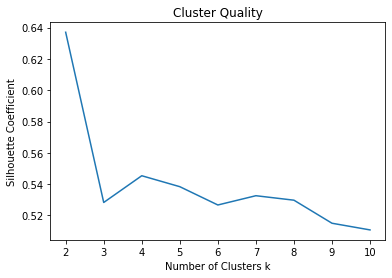

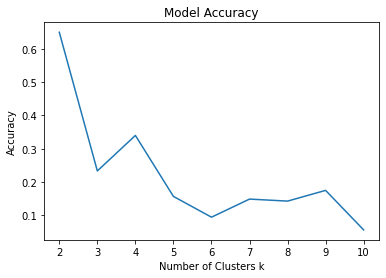

In [26]:
fig1, ax1 = plt.subplots()
ax1.set_title("Cluster Quality")
ax1.set_ylabel("Silhouette Coefficient")
ax1.set_xlabel("Number of Clusters k")
ax1.plot(cluster_num, scores)

fig2, ax2 = plt.subplots()
ax2.set_title("Model Accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Number of Clusters k")
ax2.plot(cluster_num, accuracies)
print("Best Accuracy: " + str(best_acc))

In [27]:
best_predicted

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,

In [28]:
pos_x, pos_y = encoded_val[Y_val==0,0], encoded_val[Y_val==0,1]
neg_x, neg_y = encoded_val[Y_val==1,0], encoded_val[Y_val==1,1]


pred_pos_x, pred_pos_y = encoded_val[best_predicted==0,0], encoded_val[best_predicted==0,1]
pred_neg_x, pred_neg_y = encoded_val[best_predicted==1,0], encoded_val[best_predicted==1,1]

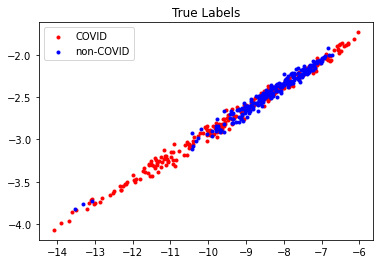

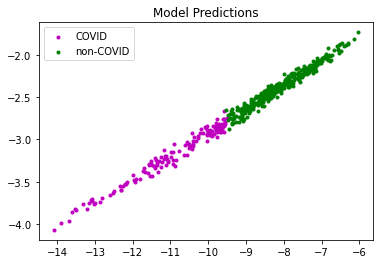

In [29]:
fig1, ax1 = plt.subplots()
ax1.set_title("True Labels")

ax1.scatter(pos_x, pos_y, marker='.', c='r', label='COVID')
ax1.scatter(neg_x, neg_y, marker='.', c='b', label='non-COVID')

ax1.legend()


fig2, ax2 = plt.subplots()
ax2.set_title("Model Predictions")

ax2.scatter(pred_pos_x, pred_pos_y, marker='.', c='m', label='COVID')
ax2.scatter(pred_neg_x, pred_neg_y, marker='.', c='g', label='non-COVID')

ax2.legend()

plt.show()